In [1]:
import pandas as pd
import os
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pdb

In [2]:
import seaborn as sns

In [3]:
from matplotlib import __version__

In [4]:
from neuralprophet import NeuralProphet

In [5]:
data_dir = "./data/"
dataset = './data/tuples/autovac/autovacon_ycsb_scale_50_worktime_3600_samplefreq_1_tsizeAnddeadtuple_pgconfig_delete_25_dead_tup_dtw.csv'

In [6]:
df = pd.read_csv(dataset)

In [7]:
df.head()

,ds,table_name,pg_stat_get_live_tuples,pg_stat_get_dead_tuples,pg_table_size,relid,schemaname,relname,seq_scan,seq_tup_read,...,n_mod_since_analyze,n_ins_since_vacuum,last_vacuum,last_autovacuum,last_analyze,last_autoanalyze,vacuum_count,autovacuum_count,analyze_count,autoanalyze_count
0,1.650448e+09,public.usertable,50000,0,58556416,16943,public,usertable,1,0,...,50000,50000,NaN,NaN,NaN,NaN,0,0,0,0
1,1.650448e+09,public.usertable,50000,0,58638336,16943,public,usertable,1,0,...,50000,50000,NaN,NaN,NaN,NaN,0,0,0,0
2,1.650448e+09,public.usertable,49963,398,59097088,16943,public,usertable,1,0,...,50530,50097,NaN,NaN,NaN,NaN,0,0,0,0
3,1.650448e+09,public.usertable,49923,894,59588608,16943,public,usertable,1,0,...,51207,50238,NaN,NaN,NaN,NaN,0,0,0,0
4,1.650448e+09,public.usertable,49894,1395,60112896,16943,public,usertable,1,0,...,51912,50396,NaN,NaN,NaN,NaN,0,0,0,0


In [37]:
df.columns

Index(['ds', 'table_name', 'pg_stat_get_live_tuples',
       'pg_stat_get_dead_tuples', 'pg_table_size', 'relid', 'schemaname',
       'relname', 'seq_scan', 'seq_tup_read', 'idx_scan', 'idx_tup_fetch',
       'n_tup_ins', 'n_tup_upd', 'n_tup_del', 'n_tup_hot_upd', 'n_live_tup',
       'n_dead_tup', 'n_mod_since_analyze', 'n_ins_since_vacuum',
       'last_vacuum', 'last_autovacuum', 'last_analyze', 'last_autoanalyze',
       'vacuum_count', 'autovacuum_count', 'analyze_count',
       'autoanalyze_count'],
      dtype='object')

In [8]:
df['ds'] = df['ds']-df['ds'].min()
df['ds'] = pd.to_datetime(df['ds'], unit='s').round('s')
df['pg_table_size'] = df['pg_table_size']//(2<<10)

In [9]:
def train_model(df, col, n_forecasts):
    
    m = NeuralProphet(n_lags=1, n_forecasts=10)
    metrics = m.fit(df[:df.shape[0]], freq="s")
    return m

In [32]:
def make_chart(df, col, table_name, n_forecasts):
    df = df[df.table_name == table_name]
    fdf = pd.DataFrame({'ds': df.ds, 'y': df[col]})
    m = train_model(fdf, col, n_forecasts)
    forecast = m.predict(fdf)
    forecast = forecast[n_forecasts+1:fdf.shape[0]]
#     fdf = fdf[n_forecasts+1:-n_forecasts-1]
#     yhat = forecast['yhat'+str(n_forecasts)]
    yhat = forecast['yhat'+str(n_forecasts)]
    tensecpred = pd.concat([pd.DataFrame({'ds': fdf.ds, table_name: forecast['y'], 'data': 'actual'}), 
               pd.DataFrame({'ds': forecast.ds, table_name: yhat, 'data': str(n_forecasts)+'secondprediction'})])
#     pdb.set_trace()
    print('mae', mean_absolute_error(forecast['y'], yhat))
    print('rmse', mean_squared_error(forecast['y'], yhat))
#     return sns.lineplot(data=tensecpred.reset_index(), x='ds', y=table_name, hue='data')
    return (tensecpred.reset_index(), mean_absolute_error(forecast['y'], yhat), mean_squared_error(forecast['y'], yhat), table_name, col, n_forecasts)

In [38]:
predictions = []
for col in ('pg_table_size', 'n_dead_tup'):
    for i, tab in enumerate(df.table_name.unique()):
        dat = make_chart(df, col, tab, 10)
        predictions.append(dat)

INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.forecaster.__handle_missing_data) - 95 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 95 NaN values in column y were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs 

  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.46E-01, min: 2.72E+00


  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.46E-01, min: 2.72E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.82E-01
Epoch[133/133]: 100%|██████████| 133/133 [00:25<00:00,  5.23it/s, SmoothL1Loss=7.34e-7, MAE=521, RMSE=815, RegLoss=0]        
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.352% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.forecaster.__handle_missing_data) - 95 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 95 NaN values in column y were auto-imputed.
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equ

  0%|          | 0/139 [00:00<?, ?it/s]

mae 535.2048293779482
rmse 520322.5917744092


INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.34E+00, min: 7.41E-02


  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.04E-01, min: 7.41E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 5.48E-01
Epoch[133/133]: 100%|██████████| 133/133 [00:27<00:00,  4.88it/s, SmoothL1Loss=0.0104, MAE=501, RMSE=1.23e+3, RegLoss=0]  
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.344% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.df_utils._infer_frequency) - Major frequency S corresponds to 97.352% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - s
INFO - (NP.forecaster.__handle_missing_data) - 95 missing dates added.
INFO - (NP.forecaster.__handle_missing_data) - 95 NaN values in column y were auto-imputed.


mae 797.0292615943426
rmse 3594612.9221694297


In [45]:
def make_plot(predictions):
    dat, mae, mse, table_name, col, n_forecasts  = predictions
    print('mae', mae, 'mse', mse, table_name, col, 'forecast period (s)', n_forecasts)
    return sns.lineplot(data=dat, x='ds', y=table_name, hue='data')

mae 535.2048293779482 mse 520322.5917744092 public.usertable pg_table_size forecast period (s) 10
mae 797.0292615943426 mse 3594612.9221694297 public.usertable n_dead_tup forecast period (s) 10


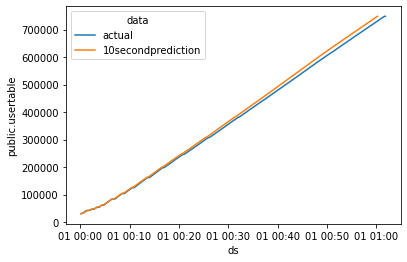

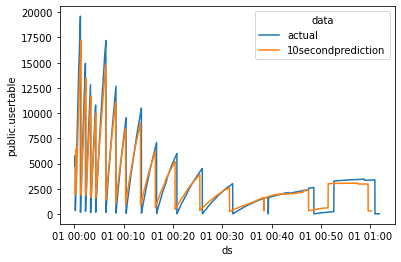

In [46]:
for i in range(len(predictions)):
    plt.figure()
    make_plot(predictions[i])